In [9]:
import numpy as np
import astropy.units as u
import time
from datetime import datetime
today = int(datetime.today().strftime('%Y%m%d'))
import copy
from importlib import reload
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import multiprocessing
from IPython.display import clear_output, display
import subprocess
import glob
from pathlib import Path
import os
from scipy.optimize import curve_fit

import magpyx
from magpyx.utils import ImageStream
import purepyindi
from purepyindi import INDIClient
client0 = purepyindi.INDIClient('localhost', 7624)
client0.start()

from math_module import xp, xcipy, np_array
import utils
import fsm_utils
import cam_utils
import telem
from imshows import imshow1, imshow2, imshow3

cwd = Path(os.getcwd())

wavelength = 633e-9
fl = 450e-3
fsm_pupil_diam = 7.1e-3
as_per_lamD = (wavelength/fsm_pupil_diam*u.radian).to(u.arcsec)
print(as_per_lamD)

lamD_per_pix = 3.45e-6 / (fl * wavelength/fsm_pupil_diam) # lamD per pixel
print(1/lamD_per_pix)

as_per_pix = lamD_per_pix * as_per_lamD
print(as_per_pix)

zero = np.array([[0,0,0]]).T
v_bias = np.array([[50,50,50]]).T


18.389524275269295 arcsec
11.62890385793019
1.581363514561072 arcsec


In [2]:
reload(cam_utils)
cam = cam_utils.CAM('campupil')


In [30]:
npsf = 32
cam.set_roi(575, 900, npsf, client0)

In [6]:
cam.set_exptime(0.0001, client0)

INFO:utils:Got semaphore index 0.


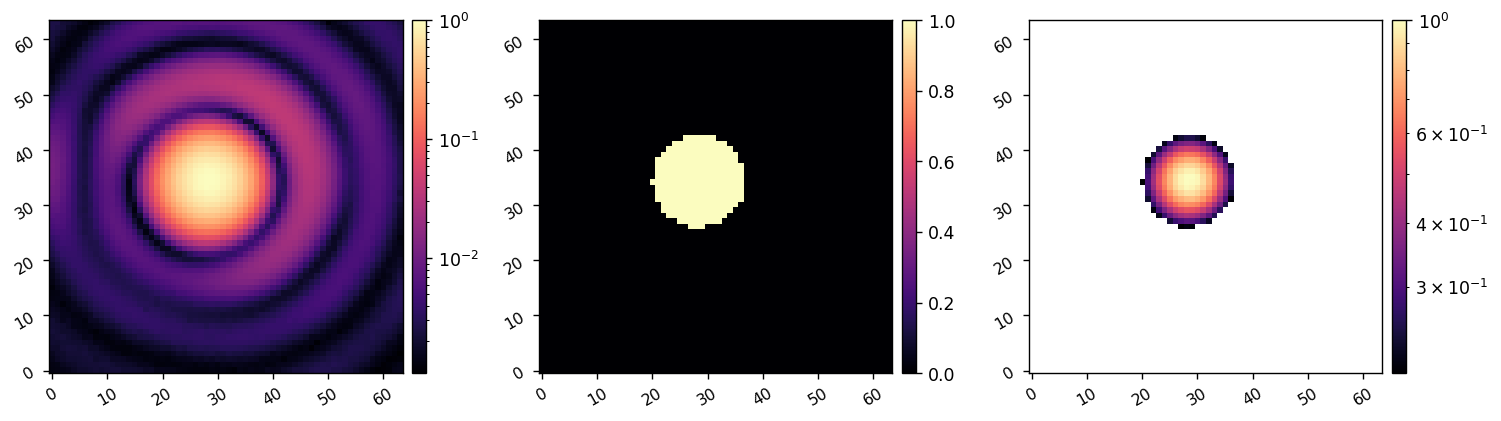

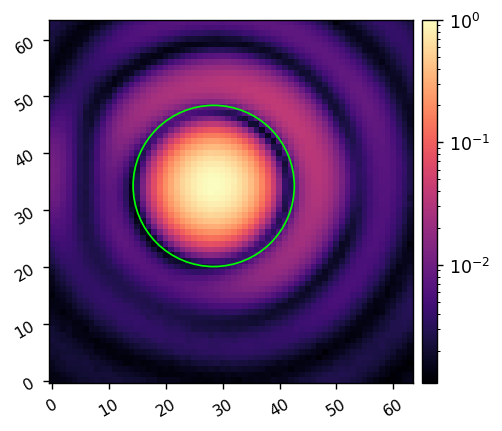

In [3]:
cam.Nframes = 1000
im_bias = cam.snap()

reload(utils)
cen = utils.centroid(im_bias, thresh=0.2, plot=True)
imshow1(im_bias, lognorm=True, patches=[Circle(cen, 1.22/lamD_per_pix, fill=False, color='lime')])


# Setup FSM Interface

In [4]:
fsm_bias_channel = ImageStream('dm00disp00')
fsm_channel = ImageStream('dm00disp10')

In [30]:
fsm_channel.write(zero)

In [29]:
fsm_bias_channel.write(v_bias)

In [109]:
fsm_bias_channel.write(zero)
fsm_channel.write(zero)

# Setup and record the modulation

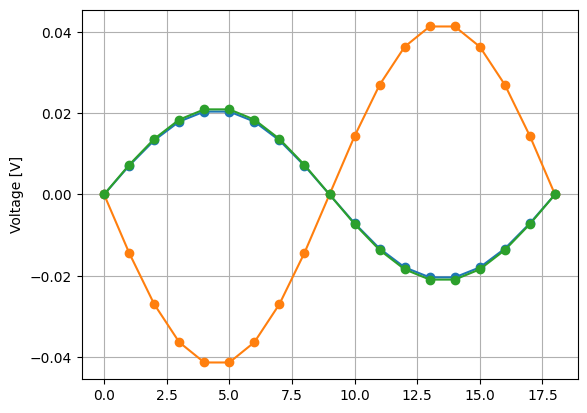

In [31]:
def modulate_fsm(commands, desired_interval, offset=0):
    print('Modulating FSM ...')
    i = 0
    Nsamps = commands.shape[0]
    total_interval = desired_interval - offset
    while True:
        if i+1==Nsamps: i = 0
        fsm_channel.write(commands[i])
        time.sleep(total_interval)
        i += 1
        
samps_per_wave = 19
amp = 1*u.arcsec/5

volt_commands = np.zeros((samps_per_wave, 3, 1))
wave = amp * np.sin(2*np.pi * np.arange(samps_per_wave)/(samps_per_wave-1))
for i in range(samps_per_wave):
    volt_commands[i] = fsm_utils.get_fsm_volts(tip=wave[i], tilt=0*u.arcsec)
    # volt_commands[i] = fsm_utils.get_fsm_volts(tip=0*u.arcsec, tilt=wave[i])

plt.subplot(111)
# plt.plot(wave)
plt.plot(volt_commands[:,0], '-o')
plt.plot(volt_commands[:,1], '-o')
plt.plot(volt_commands[:,2], '-o')
plt.ylabel('Voltage [V]')
plt.grid()
plt.show()

In [32]:
sin_freq = 5
total_freq = sin_freq * (samps_per_wave-1)
desired_interval = 1/total_freq
print(desired_interval, total_freq)

exp_dir = f'sin-tip-{sin_freq:.2f}'
exp_parent_path = Path(f'{cwd}/data/{today}-exps')
exp_path = exp_parent_path / exp_dir
fsm_data_path = exp_path / 'fsm'
cam_data_path = exp_path / 'cam'

telem.make_dir(exp_path)
telem.make_dir(exp_parent_path)
telem.make_dir(fsm_data_path)
telem.make_dir(cam_data_path)

0.011111111111111112 90
Directory '/home/uasal/Projects/fsm-exps/data/20250731-exps/sin-tip-5.00' already exists.
Directory '/home/uasal/Projects/fsm-exps/data/20250731-exps' already exists.
Directory '/home/uasal/Projects/fsm-exps/data/20250731-exps/sin-tip-5.00/fsm' already exists.
Directory '/home/uasal/Projects/fsm-exps/data/20250731-exps/sin-tip-5.00/cam' already exists.


In [33]:
reload(telem)
telem.delete_files(cam_data_path/'*')
telem.delete_files(fsm_data_path/'*')
telem.delete_files(telem.cam_path/'*')
telem.delete_files(telem.fsm_path/'*')

In [34]:
reload(telem)
mod = multiprocessing.Process(
    name='FSM Modulation', 
    target=modulate_fsm, 
    args=[volt_commands, desired_interval], 
    kwargs={'offset':80e-6},
)

t_meas = 2
delay = 1

cam.Nframes = 100
frame0 = cam.snap()
utils.save_fits(str(cam_data_path/'campupil_0.fits'), frame0)

mod.start()
time.sleep(delay)

telem.toggle_telem_fsm_and_cam(1, client0)
time.sleep(t_meas)
telem.toggle_telem_fsm_and_cam(0, client0)

time.sleep(delay)
mod.terminate()

fsm_channel.write(zero)

# Move the files to the defined data directories
telem.move_files(telem.cam_path, cam_data_path)
telem.move_files(telem.fsm_path, fsm_data_path)

Saved data to:  /home/uasal/Projects/fsm-exps/data/20250731-exps/sin-tip-5.00/cam/campupil_0.fits
Modulating FSM ...
Moved files from /opt/MagAOX/rawimages/campupil to /home/uasal/Projects/fsm-exps/data/20250731-exps/sin-tip-5.00/cam
Moved files from /opt/MagAOX/rawimages/fsm to /home/uasal/Projects/fsm-exps/data/20250731-exps/sin-tip-5.00/fsm


# Analyze data

In [35]:
reload(telem)
telem.unpack_data(cam_data_path, cam_data_path)
telem.unpack_data(fsm_data_path, fsm_data_path)


In [36]:
reload(telem)

cam_data_fnames = telem.get_fnames(cam_data_path/'campupil*20250212*.fits')
fsm_data_fnames = telem.get_fnames(fsm_data_path/'dm00disp*20250212*.fits')

cam_data_fnames = telem.get_fnames(cam_data_path/'campupil*20250731*.fits')
fsm_data_fnames = telem.get_fnames(fsm_data_path/'dm00disp*20250731*.fits')

fsm_data_fnames[0], cam_data_fnames[0]

('/home/uasal/Projects/fsm-exps/data/20250731-exps/sin-tip-5.00/fsm/dm00disp_20250731184449456376981.fits',
 '/home/uasal/Projects/fsm-exps/data/20250731-exps/sin-tip-5.00/cam/campupil_20250731184449456941129.fits')

67489.456376981
67489.456941129
-0.0005641479947371408


Text(0.5, 0, 'frame count')

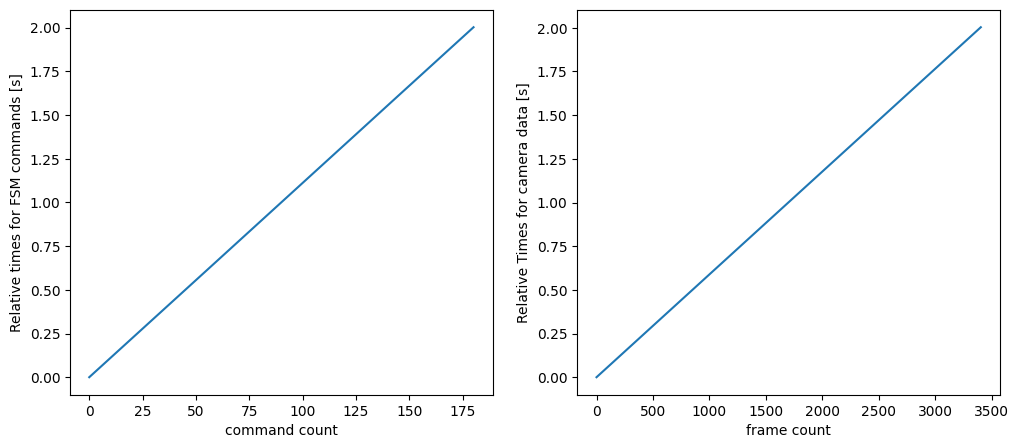

In [37]:
from astropy.io import fits

fsm_commands = []
fsm_times = []
for fname in fsm_data_fnames:
    fsm_commands.append(fits.getdata(fname))
    t_hr = float(fname.split("_")[1][8:10])
    t_min = float(fname.split("_")[1][10:12])
    t_sec = float(fname.split("_")[1][12:-5])/1e9
    fsm_times.append( 3600*t_hr + 60*t_min + t_sec )
fsm_commands = np.array(fsm_commands) 
fsm_times = np.array(fsm_times)
fsm_start = fsm_times[0]
rel_fsm_times = fsm_times - fsm_start

frames = []
cam_times = []
for fname in cam_data_fnames:
    frames.append(fits.getdata(fname))
    t_hr = float(fname.split("_")[1][8:10])
    t_min = float(fname.split("_")[1][10:12])
    t_sec = float(fname.split("_")[1][12:-5])/1e9
    cam_times.append( 3600*t_hr + 60*t_min + t_sec )
frames = np.array(frames) 
cam_times = np.array(cam_times)
cam_start = cam_times[0]
rel_cam_times = cam_times - fsm_start

print(fsm_start) 
print(cam_start)
print(fsm_start - cam_start)

plt.figure(figsize=(12,5))
plt.subplot(121)
plt.plot(rel_fsm_times)
plt.ylabel('Relative times for FSM commands [s]')
plt.xlabel('command count')

plt.subplot(122)
plt.plot(rel_cam_times)
plt.ylabel('Relative Times for camera data [s]')
plt.xlabel('frame count')

0.011111111111111112 0.011126761155497256
90 89.87341293885353
5 4.992967385491863


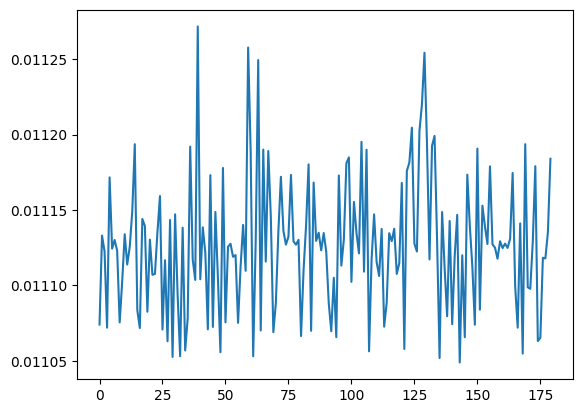

In [38]:
fsm_time_steps = (rel_fsm_times[1:] - rel_fsm_times[:-1])
print(desired_interval, np.mean(fsm_time_steps))
print(total_freq, 1/np.mean(fsm_time_steps))
print(sin_freq, 1/np.mean(fsm_time_steps) / (samps_per_wave-1))
plt.plot(fsm_time_steps)

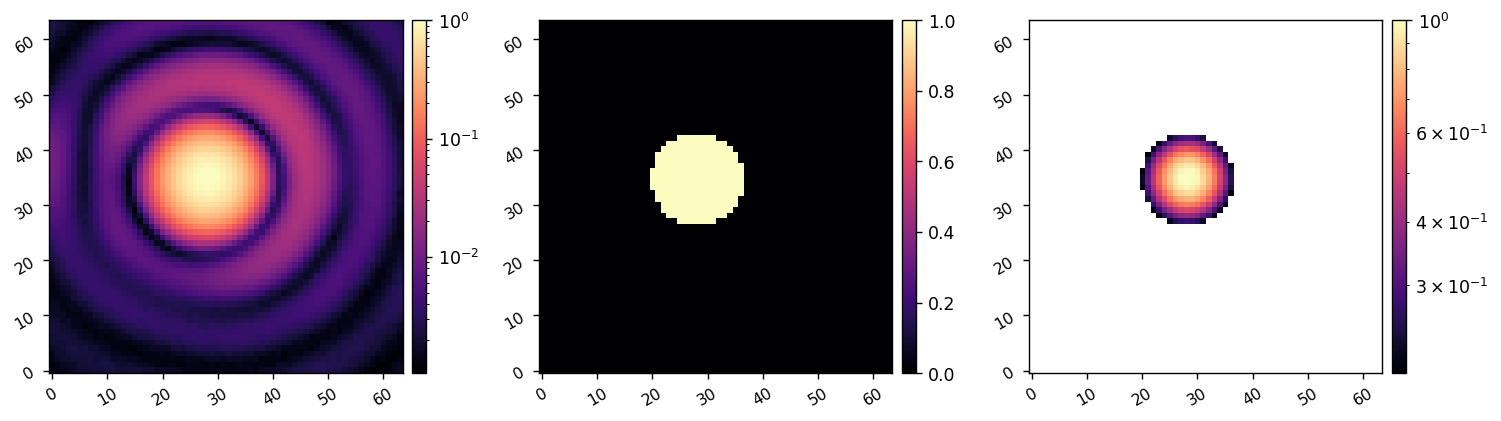

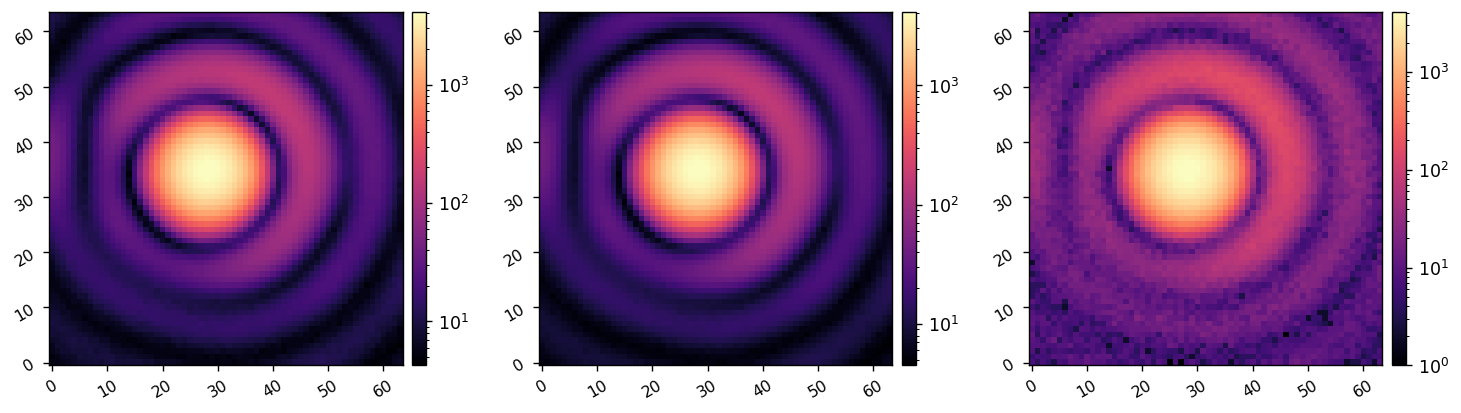

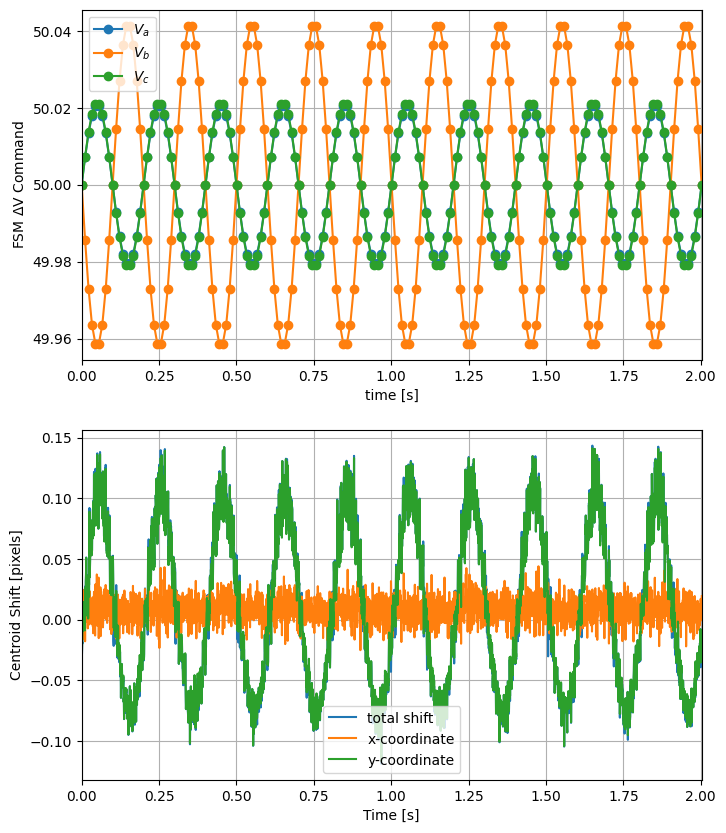

In [39]:
cthresh = 0.2

xmax = rel_fsm_times.max()
# xmax = 0.5

N = len(cam_data_fnames)
frame0 = utils.load_fits(str(cam_data_path/'campupil_0.fits'))
cen_0 = utils.centroid(frame0.astype(float), thresh=cthresh, plot=True)
mean_frame = np.mean(frames, axis=0)
imshow3(frame0, mean_frame, frames[0], lognorm=True)

shift_pix = []
total_shift_pix = []
for i in range(N):
    cen = utils.centroid(frames[i].astype(float), thresh=cthresh, plot=0)
    shift = cen - cen_0
    shift_pix.append(shift)
    if shift[1]>0:
        total_shift_pix.append(np.sqrt(shift[0]**2 + shift[1]**2))
    elif shift[1]<0:
        total_shift_pix.append(-np.sqrt(shift[0]**2 + shift[1]**2))
shift_pix = np.array(shift_pix)
total_shift_pix = np.array(total_shift_pix)

shift_as = shift_pix * as_per_pix
total_shift_as = total_shift_pix * as_per_pix

fig = plt.figure(figsize=(8,10))
plt.subplot(211)
plt.plot(rel_fsm_times, fsm_commands[:,0], '-o', label='$V_a$')
plt.plot(rel_fsm_times, fsm_commands[:,1], '-o', label='$V_b$')
plt.plot(rel_fsm_times, fsm_commands[:,2], '-o', label='$V_c$')
plt.ylabel('FSM $\Delta$V Command')
plt.xlabel('time [s]')
plt.xlim([0, xmax])
# plt.xlim([0, 1])
plt.grid()
plt.legend()

plt.subplot(212)
plt.plot(rel_cam_times, total_shift_pix, label='total shift')
plt.plot(rel_cam_times, shift_pix[:,0], label='x-coordinate')
plt.plot(rel_cam_times, shift_pix[:,1], label='y-coordinate')
plt.ylabel('Centroid Shift [pixels]')

# plt.plot(rel_cam_times, total_shift_as, label='total shift')
# plt.plot(rel_cam_times, shift_as[:,0], label='x-coordinate')
# plt.plot(rel_cam_times, shift_as[:,1], label='y-coordinate')
# plt.ylabel('Centroid Shift [as]')

plt.xlabel('Time [s]')
plt.xlim([0, xmax])
# plt.xlim([0, 1])
plt.grid()
plt.legend()

plt.show()

[-1.03579937e-01  4.99523062e-01 -4.07964832e-05  5.00000000e+01]
-4.0796483233532115e-05


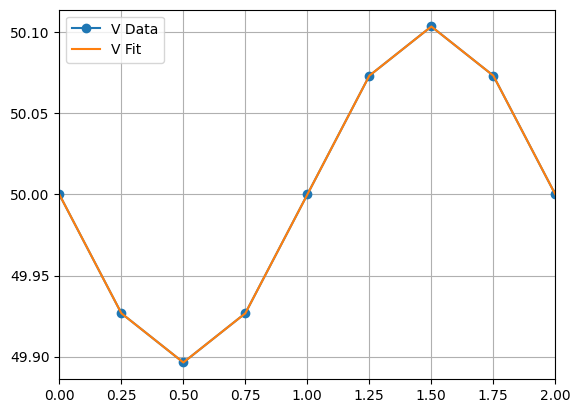

[-0.8073084   0.48609587 -0.36179676  0.04187782]
-0.3617967572824395


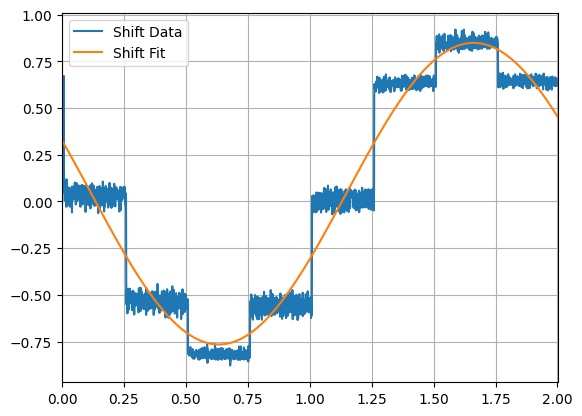

-0.002337466308257616 -20.729427233802813
20.727089767494554


In [ ]:
reload(fsm_utils)

xmax = rel_fsm_times.max()
# xmax = 0.5

# Fit the voltage command data
x = rel_fsm_times
y = fsm_commands[:,0][:,0]

amp0 = (y.max() - y.min())/2
freq0 = sin_freq
offset0 = y.max() - amp0
popt, _ = curve_fit(
    fsm_utils.sine_func, 
    x, y, 
    p0=[amp0, freq0, 0, offset0],
    maxfev=100000,
)
print(popt)
phase = popt[2]
if phase>np.pi/2:
    phase = popt[2] - np.pi
elif phase<-np.pi/2:
    phase = popt[2] + np.pi
print(phase)
fsm_data_phase = phase * 180/np.pi

# Plot results
plt.plot(x, y, '-o', label='V Data')
plt.plot(x, fsm_utils.sine_func(x, *popt), label='V Fit')
plt.xlim([0, xmax])
plt.grid()
plt.legend()
plt.show()

# Fit the camera data
x = rel_cam_times
y = total_shift_as.value

amp0 = (y.max() - y.min())/2
freq0 = sin_freq
offset0 = y.max() - amp0
popt, _ = curve_fit(
    fsm_utils.sine_func, 
    x, y, 
    p0=[amp0, freq0, 0, offset0],
    maxfev=100000,
) 
print(popt)
phase = popt[2]
if phase>np.pi/2:
    phase = popt[2] - np.pi
elif phase<-np.pi/2:
    phase = popt[2] + np.pi
print(phase)
cam_data_phase = phase* 180/np.pi

# Plot results
plt.plot(x, y, label='Shift Data')
plt.plot(x, fsm_utils.sine_func(x, *popt), label='Shift Fit')
plt.xlim([0, xmax])
plt.grid()
plt.legend()
plt.show()

rel_phase = (fsm_data_phase - cam_data_phase)
print(fsm_data_phase, cam_data_phase)
print(rel_phase)